In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import pickle as pkl
import random
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import tensorflow as tf
import keras
import keras_metrics as km

from keras.callbacks import TensorBoard
from keras import regularizers
from custom_callbacks import LrFinder
from custom_callbacks import CycleLearner
from custom_callbacks import reset_weights
from keras.callbacks import ModelCheckpoint
from time import time
from keras.layers import Input, Dense,Dropout,BatchNormalization,LSTM,GRU,Bidirectional,Conv2D, MaxPool2D, Flatten, GlobalAvgPool2D, GlobalMaxPool2D,merge
from keras.models import Model,Sequential
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.optimizers import Adagrad
from keras.optimizers import Adamax
from keras.optimizers import Nadam
from keras import backend as K
import math
import json

# Get the dictionary containing each metric and the loss for each epoch


Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3174588267562054062
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11214562919
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16652678143998656269
physical_device_desc: "device: 0, name: TITAN Xp, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


In [3]:
train_filepath = "train_workspace/"
animalList = ["Human","Pig","Chicken","Rat","Mouse","Dog"]
levelList = ["Strict","Relaxed","Intermediate"]
dataList = ["Ohnologs","No-Ohnologs","Paralogs"]
dataNameList = ["ohnologs","no-ohnologs","paralog"]
sb.set_style("darkgrid")

In [4]:
working_level = "Strict"
kmer_chosen = 8
type_chosen = "cdna"

dataset_complete = pd.read_pickle(train_filepath + working_level + "/datasets/2_paralog_dataset_complete-" + str(kmer_chosen) + "-" + type_chosen + ".pkl")
dataset_complete_soft = pd.read_pickle(train_filepath + working_level + "/datasets/3_paralog_dataset_complete-" + str(kmer_chosen) + "-" + type_chosen + ".pkl")

In [5]:
new_classes = []
for index, row in dataset_complete_soft.iterrows():
    if(row["Is_Ohnolog"] == 1):
        new_classes.append(1)
    else:
        if(row["Is_Paralog"] == 0):
            new_classes.append(0)
        else:
            new_classes.append(2)
dataset_complete_soft["Dup_Class"] = new_classes
dataset_complete_soft.head()

,Specie_Chicken,Specie_Dog,Specie_Human,Specie_Mouse,Specie_Pig,Specie_Rat,Is_Ohnolog,Is_Paralog,Sequence-1 GC,Sequence-1 Length,...,Embedding2_91,Embedding2_92,Embedding2_93,Embedding2_94,Embedding2_95,Embedding2_96,Embedding2_97,Embedding2_98,Embedding2_99,Dup_Class
0,0,0,1,0,0,0,1,0.0,0.429090,0.030467,...,35.407509,23.369914,8.144324,-26.702099,241.207709,-12.695194,-79.573883,121.379307,-69.633950,1
1,0,0,1,0,0,0,1,0.0,0.441268,0.053554,...,12.556002,23.217834,3.162621,-18.980361,204.830682,-20.962017,-61.163222,122.543777,-26.694989,1
2,0,0,1,0,0,0,1,0.0,0.357972,0.111632,...,-6.850837,12.314794,-3.387437,-5.403946,93.521862,4.187927,-35.880841,50.565405,-9.853733,1
3,0,0,1,0,0,0,1,0.0,0.684226,0.031676,...,68.287420,6.295047,37.820265,-33.841090,230.696114,-60.500167,-82.975793,174.224105,-111.569089,1
4,0,0,1,0,0,0,1,0.0,0.402629,0.018732,...,18.025175,13.675959,21.304353,-2.702105,162.972440,-8.209692,-46.736790,62.650600,-39.056701,1


## Start Designing

In [6]:
blast_columns = ["Percent Identical Matches","Aligment Length","Nr Mismatch","Nr Gap Open","Evalue","Bit Score"]

e_values_columns = ["Evalue_Total","Evalue_High","Evalue_Medium","Evalue_Low"]

blast_types = ["High","Medium","Low","Total"]
blast_col_Total = [i + "_Total" for i in blast_columns] 
blast_col_High = [i + "_High" for i in blast_columns]
blast_col_Medium = [i + "_Medium" for i in blast_columns]
blast_col_Low = [i + "_Low" for i in blast_columns]

blast_cols_levels = blast_col_High + blast_col_Medium + blast_col_Low
total_columns = (blast_col_High + blast_col_Medium + blast_col_Low + blast_col_Total + ["Nr Hits"])

non_training_meta_features = ["Sequence-1","Sequence-2","Sequence-1 Id","Sequence-1-Transcript Id","Sequence-2 Id","Sequence-2-Transcript Id","Sequence-1-Transcript-Version","Sequence-2-Transcript-Version"]

sequence_1_metadata = ["Sequence-1 GC","Sequence-1 Length","Sequence-1-Chromosome","Seq-1-Biotype_protein_coding"]
sequence_2_metadata = ["Sequence-2 GC","Sequence-2 Length","Sequence-2-Chromosome","Seq-2-Biotype_protein_coding"]

sequence_1_metadata_diferential = ["Sequence-1 GC","Sequence-1 Length"]
sequence_2_metadata_diferential = ["Sequence-2 GC","Sequence-2 Length"]

sequence_1_metadata_categorical = ["Sequence-1-Chromosome","Seq-1-Biotype_protein_coding"]
sequence_2_metadata_categorical = ["Sequence-2-Chromosome","Seq-2-Biotype_protein_coding"]

species_metadata = ["Specie_Chicken","Specie_Dog","Specie_Human","Specie_Mouse","Specie_Pig","Specie_Rat"]

emb_size = 100
if(type_chosen == "cdna2"):
    emb_size = 200
embedding_1_cols = ["Embedding1_" + str(i) for i in range(0,emb_size)]
embedding_2_cols = ["Embedding2_" + str(i) for i in range(0,emb_size)]

## Models

In [7]:
def get_train_val_test(df):
    df.sample(frac=1,random_state=7)
    df_train, df_test = train_test_split(df, test_size=0.2,random_state=9,stratify=dataset_complete["Is_Ohnolog"])
    df_train, df_val = train_test_split(df_train, test_size=0.2,random_state=3,stratify=df_train["Is_Ohnolog"])
    return (df_train,df_val,df_test)

In [8]:
def get_train_val_test_soft(df):
    df.sample(frac=1,random_state=7)
    df_train, df_test = train_test_split(df, test_size=0.2,random_state=9,stratify=dataset_complete["Dup_Class"])
    df_train, df_val = train_test_split(df_train, test_size=0.2,random_state=3,stratify=df_train["Dup_Class"])
    return (df_train,df_val,df_test)

In [9]:
def save_log(log,name):
    log_dict = log.history    
    json.dump(log_dict, open(train_filepath + working_level + "/model_run_history/" + name + ".json", 'w'))

In [10]:
def get_log(name):
     return json.load(open(train_filepath + working_level + "/model_run_history/" + name + ".json", 'r'))

In [11]:
class EpochLogger(keras.callbacks.Callback):
    def __init__(self, display):
        self.step = 0
        self.display = display
        self.metric_cache = {}        

    def on_epoch_end(self, epoch, logs={}):
        self.step += 1
        for k in self.params['metrics']:
            if k in logs:
                self.metric_cache[k] = self.metric_cache.get(k, 0) + logs[k]
        if self.step % self.display == 0:
            metrics_log_default = ''            
            metrics_log_main = ''            
            metrics_log_aux = ''            
            for (k, v) in self.metric_cache.items():
                val = v / self.display             
                if("main" in k):
                    if abs(val) > 1e-3:
                        metrics_log_main += ' - %s: %.4f' % (k, val)
                        continue      
                    else:
                        metrics_log_main += ' - %s: %.4e' % (k, val)
                        continue                    
                        
                if("aux" in k): 
                    if abs(val) > 1e-3:
                        metrics_log_aux += ' - %s: %.4f' % (k, val)
                        continue      
                    else:
                        metrics_log_aux += ' - %s: %.4e' % (k, val)
                        continue      
                        
                if abs(val) > 1e-3:
                        metrics_log_default += ' - %s: %.4f' % (k, val)
                else:
                        metrics_log_default += ' - %s: %.4e' % (k, val)                        
                    
            print('step: {}/{} ... {}'.format(self.step,
                                          self.params['epochs'],
                                          metrics_log_default + "\n" + metrics_log_main + "\n" + metrics_log_aux))
            self.metric_cache.clear()

## Change here to use complete or diferential

In [12]:
model_name = ""

chosen_df = dataset_complete

model_name += 'complete' + '-' + str(kmer_chosen) + "-" + type_chosen 

df_train,df_val,df_test = get_train_val_test(chosen_df)
df_train.head()

,Specie_Chicken,Specie_Dog,Specie_Human,Specie_Mouse,Specie_Pig,Specie_Rat,Is_Ohnolog,Is_Paralog,Sequence-1 GC,Sequence-1 Length,...,Embedding2_90,Embedding2_91,Embedding2_92,Embedding2_93,Embedding2_94,Embedding2_95,Embedding2_96,Embedding2_97,Embedding2_98,Embedding2_99
4771,0,0,0,0,1,0,1,0.0,0.588828,0.107087,...,18.366759,-34.492606,-201.816264,-28.866334,-184.644555,-30.979461,-199.505339,29.858131,-2.315493,-220.552949
1917,0,0,1,0,0,0,0,1.0,0.401499,0.305603,...,-2.353507,16.591102,5.454374,6.608200,-6.457835,79.053392,1.704520,-35.067641,32.010599,-35.969026
477,0,0,1,0,0,0,0,1.0,0.555812,0.213428,...,-32.489602,44.072336,9.095859,20.958767,-5.166646,84.594934,6.961697,-43.727784,43.267274,-36.220485
471,0,0,1,0,0,0,0,0.0,0.379268,0.346116,...,-8.410912,12.858401,4.943984,0.680857,-25.709318,142.847078,-37.053429,-72.551393,101.345665,-56.910313
1789,0,0,1,0,0,0,0,1.0,0.399401,0.223122,...,-30.771628,41.727533,0.581152,8.004260,-29.905225,163.781503,-2.035721,-69.771758,75.522265,-65.095699


In [13]:
def show_results(model, log,x_test,y_test,bs,cycling=False):
    print(model.evaluate(x_test, y_test, batch_size=bs, verbose=False))
    loss, acc,recall = model.evaluate(x_test, y_test, batch_size=bs, verbose=False)
    print(f'Loss     = {loss:.4f}')
    print(f'Accuracy = {acc:.4f}')
    
    val_loss = log['val_loss']
    val_acc = log['val_acc']
    if cycling:
        val_loss += [loss]
        val_acc += [acc]
        
    fig, axes = plt.subplots(1, 2, figsize=(20,8))
    ax1, ax2 = axes
    ax1.plot(log['loss'], label='train')
    ax1.plot(val_loss, label='test')
    ax1.set_xlabel('epoch'); ax1.set_ylabel('loss')
    ax2.plot(log['acc'], label='train')
    ax2.plot(val_acc, label='test')
    ax2.set_xlabel('epoch'); ax2.set_ylabel('accuracy')
    for ax in axes: ax.legend()

In [14]:
## Flat Model
def flat_model(df_input,name):
    inputs = Input(shape=(len(df_input.columns),))
    # a layer instance is callable on a tensor, and returns a tensor
    
    x = Dense(1024, activation='relu',kernel_regularizer=regularizers.l2(0.005))(inputs)    
    x = Dropout(0.2)(x)
    x = Dense(1024, activation='relu',use_bias=False)(x)    
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.005,))(x)
    x = Dropout(0.2)(x)
    x = Dense(512, activation='relu',use_bias=False)(x)    
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.005))(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation='relu',use_bias=False)(x)    
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.00001))(x)    
    x = Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.00001))(x)
    x = Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.00001))(x)
    x = Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.00001))(x)
    x = Dense(8, activation='relu',kernel_regularizer=regularizers.l2(0.00001))(x)

    predictions = Dense(1, activation='sigmoid')(x)

    # This creates a model that includes
    # the Input layer and three Dense layers
    model_created = Model(inputs=inputs, outputs=predictions)
    model_created.Name = name
    return model_created
 

In [15]:
def fit_model(train_x,train_y,val_x,val_y,model_train,n_epochs,optimizer,batchsize,model_params = None):
    tensorboard = TensorBoard(log_dir=train_filepath + working_level + "/board_logs/" + model_train.Name + "-" + model_name + "-{}".format(time()))
    checkpoint = ModelCheckpoint(train_filepath + working_level + "/model_checkpoints/{0}-check-{{epoch:02d}}-{{val_acc:.2f}}.hdf5".format(model_train.Name + "-" + model_name),save_weights_only=True, period = int(n_epochs/5))
    best_model_save = ModelCheckpoint(train_filepath + working_level + "/model_checkpoints/{0}-best.hdf5".format(model_train.Name + "-" + model_name), monitor='val_acc', save_best_only=True,save_weights_only=True, mode='max')
    logger = EpochLogger(display=25)

    model_train.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy',km.binary_recall()])
    return model_train.fit(train_x.values, train_y.values,verbose = 0,epochs = n_epochs,batch_size=batchsize,validation_data=[val_x.values,val_y.values],callbacks = [tensorboard,checkpoint,best_model_save,logger])  # starts training

In [16]:
df_train_x = df_train.drop(["Is_Ohnolog","Is_Paralog"],axis=1)
df_train_x = df_train_x.drop(embedding_1_cols,axis=1)
df_train_x = df_train_x.drop(embedding_2_cols,axis=1)
df_train_y = df_train["Is_Ohnolog"]

df_val_x = df_val.drop(["Is_Ohnolog","Is_Paralog"],axis=1)
df_val_x = df_val_x.drop(embedding_1_cols,axis=1)
df_val_x = df_val_x.drop(embedding_2_cols,axis=1)
df_val_y = df_val["Is_Ohnolog"]

df_test_x = df_test.drop(["Is_Ohnolog","Is_Paralog"],axis=1)
df_test_x = df_test_x.drop(embedding_1_cols,axis=1)
df_test_x = df_test_x.drop(embedding_2_cols,axis=1)
df_test_y = df_test["Is_Ohnolog"]

In [18]:
model = flat_model(df_train_x,"Flat_meta_only")

In [19]:
reset_weights(model)

In [20]:
log = fit_model(df_train_x,df_train_y,df_val_x,df_val_y,model,750,Adamax(),256)

step: 25/750 ...  - loss: 0.6019 - acc: 0.8147 - recall: 0.7908 - val_loss: 0.5317 - val_acc: 0.8110 - val_recall: 0.7977


step: 50/750 ...  - loss: 0.3946 - acc: 0.8338 - recall: 0.8134 - val_loss: 0.4101 - val_acc: 0.8251 - val_recall: 0.7904


step: 75/750 ...  - loss: 0.3815 - acc: 0.8407 - recall: 0.8190 - val_loss: 0.3971 - val_acc: 0.8299 - val_recall: 0.7948


step: 100/750 ...  - loss: 0.3698 - acc: 0.8462 - recall: 0.8256 - val_loss: 0.3837 - val_acc: 0.8378 - val_recall: 0.8113


step: 125/750 ...  - loss: 0.3655 - acc: 0.8473 - recall: 0.8281 - val_loss: 0.3753 - val_acc: 0.8415 - val_recall: 0.8274


step: 150/750 ...  - loss: 0.3611 - acc: 0.8489 - recall: 0.8297 - val_loss: 0.3720 - val_acc: 0.8431 - val_recall: 0.8238


step: 175/750 ...  - loss: 0.3575 - acc: 0.8503 - recall: 0.8345 - val_loss: 0.3709 - val_acc: 0.8432 - val_recall: 0.8267


step: 200/750 ...  - loss: 0.3557 - acc: 0.8507 - recall: 0.8349 - val_loss: 0.3687 - val_acc: 0.8441 - val_recall: 0.8287


ste

In [16]:
# FLat Complete with Embeddings
df_train_x = df_train.drop(["Is_Ohnolog","Is_Paralog"],axis=1)
df_train_y = df_train["Is_Ohnolog"]

df_val_x = df_val.drop(["Is_Ohnolog","Is_Paralog"],axis=1)
df_val_y = df_val["Is_Ohnolog"]

df_test_x = df_test.drop(["Is_Ohnolog","Is_Paralog"],axis=1)
df_test_y = df_test["Is_Ohnolog"]

In [17]:
model = flat_model(df_train_x,"Flat_complete")

In [18]:
reset_weights(model)

In [19]:
log = fit_model(df_train_x,df_train_y,df_val_x,df_val_y,model,500,Adamax(),256)

step: 25/500 ...  - loss: 0.8009 - acc: 0.7136 - recall: 0.5701 - val_loss: 0.7020 - val_acc: 0.7009 - val_recall: 0.5409


step: 50/500 ...  - loss: 0.5224 - acc: 0.7207 - recall: 0.5982 - val_loss: 0.5361 - val_acc: 0.7122 - val_recall: 0.5761


step: 75/500 ...  - loss: 0.5096 - acc: 0.7246 - recall: 0.6167 - val_loss: 0.5220 - val_acc: 0.7182 - val_recall: 0.5860


step: 100/500 ...  - loss: 0.5002 - acc: 0.7288 - recall: 0.6332 - val_loss: 0.5217 - val_acc: 0.7185 - val_recall: 0.5595


step: 125/500 ...  - loss: 0.4950 - acc: 0.7318 - recall: 0.6469 - val_loss: 0.5164 - val_acc: 0.7188 - val_recall: 0.6189


step: 150/500 ...  - loss: 0.4896 - acc: 0.7351 - recall: 0.6562 - val_loss: 0.5183 - val_acc: 0.7186 - val_recall: 0.5817


step: 175/500 ...  - loss: 0.4835 - acc: 0.7403 - recall: 0.6714 - val_loss: 0.5176 - val_acc: 0.7195 - val_recall: 0.5902


step: 200/500 ...  - loss: 0.4810 - acc: 0.7427 - recall: 0.6860 - val_loss: 0.5162 - val_acc: 0.7232 - val_recall: 0.6163


ste

[0.523741642588816, 0.7179195145449135, 0.7243735762822942]
Loss     = 0.5237
Accuracy = 0.7179


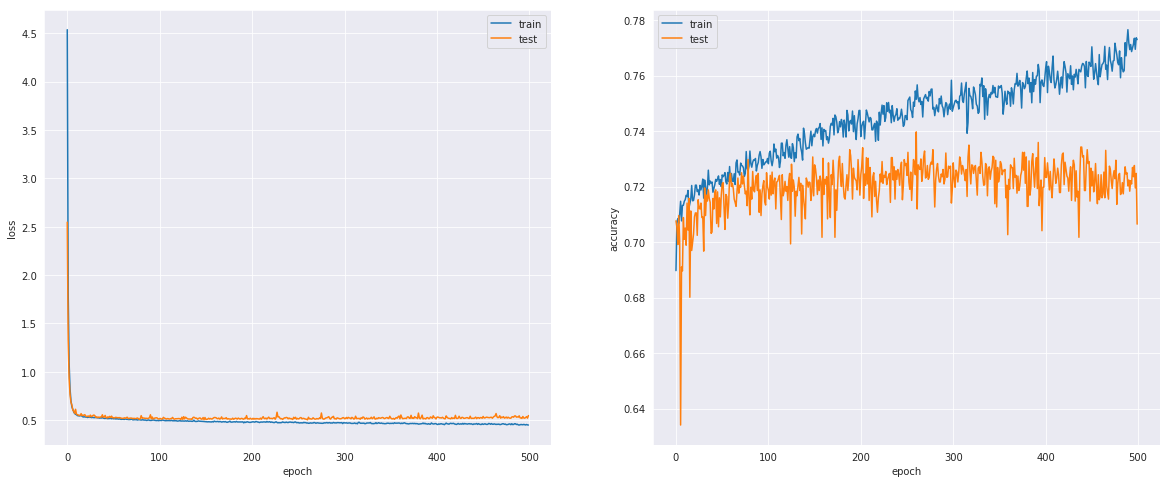

In [20]:
show_results(model,log.history,df_test_x.values,df_test_y.values,256)

## Levels

In [21]:
def show_results_level(model, log,x_test,x_emb_test,y_test,bs,metrics_used):
    metrics_names,metrics = (model.metrics_names,model.evaluate([x_emb_test.values,x_test.values],[y_test.values,y_test.values], batch_size=bs,verbose=False))
    count = 0
    for i in range(0,len(metrics)):
        print(f'{metrics_names[i]}     = {metrics[i]:.4f}')                
    nr_metrics = len(metrics_used)
    fig, axes = plt.subplots(2, nr_metrics, figsize=(18,8))   
    
    i = 0
    for metric in metrics_used:
        match_metrics = [model_metric.split('_')[0] for model_metric in metrics_names if metric in model_metric]
        print(match_metrics)
        if(metric == "loss"):
            match_metrics.remove("loss")
        for match in match_metrics:        
            if(i>=nr_metrics):
                axes[1][i-nr_metrics].plot(log[match + "_" + metric], label="Train")            
                axes[1][i-nr_metrics].plot(log["val_" + match + "_" + metric], label="Val")       
                axes[1][i-nr_metrics].set_xlabel('epoch'); 
                axes[1][i-nr_metrics].set_ylabel(metric + "_" + match)                            
            else:
                axes[0][i].plot(log[match + "_" + metric], label="Train")            
                axes[0][i].plot(log["val_" + match + "_" + metric], label="Val")       
                axes[0][i].set_xlabel('epoch'); 
                axes[0][i].set_ylabel(metric + "_" + match)                            
                
            i += 1            
    for ax in axes:
        for a in ax:
             a.legend()

In [22]:
def show_results_level_RNN(model, log,x_test,x_emb_test,y_test,bs,metrics_used):
    metrics_names,metrics = (model.metrics_names,model.evaluate([x_emb_test.values.reshape(x_emb_test.shape[0],x_emb_test.shape[1],1),x_test.values],[y_test.values,y_test.values], batch_size=bs,verbose=False))
    count = 0
    for i in range(0,len(metrics)):
        print(f'{metrics_names[i]}     = {metrics[i]:.4f}')                
    nr_metrics = len(metrics_used)
    fig, axes = plt.subplots(2, nr_metrics, figsize=(18,8))   
    
    i = 0
    for metric in metrics_used:
        match_metrics = [model_metric.split('_')[0] for model_metric in metrics_names if metric in model_metric]
        print(match_metrics)
        if(metric == "loss"):
            match_metrics.remove("loss")
        for match in match_metrics:        
            if(i>=nr_metrics):
                axes[1][i-nr_metrics].plot(log[match + "_" + metric], label="Train")            
                axes[1][i-nr_metrics].plot(log["val_" + match + "_" + metric], label="Val")       
                axes[1][i-nr_metrics].set_xlabel('epoch'); 
                axes[1][i-nr_metrics].set_ylabel(metric + "_" + match)                            
            else:
                axes[0][i].plot(log[match + "_" + metric], label="Train")            
                axes[0][i].plot(log["val_" + match + "_" + metric], label="Val")       
                axes[0][i].set_xlabel('epoch'); 
                axes[0][i].set_ylabel(metric + "_" + match)                            
                
            i += 1            
    for ax in axes:
        for a in ax:
             a.legend()

In [23]:
def level_model(df_meta_input,df_embeddings,name):    
    input_embedding = Input(shape=(len(df_embeddings.columns),), name='embedding_input')        
    emb_x = Dense(512, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.01))(input_embedding)    
    emb_x = BatchNormalization()(emb_x)
    emb_x = Dropout(0.4)(emb_x)
    emb_x = Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.01))(emb_x)
    emb_x = Dropout(0.4)(emb_x)
    emb_x = Dense(256, activation='relu',use_bias = False,kernel_regularizer=regularizers.l2(0.01))(emb_x)    
    emb_x = Dropout(0.3)(emb_x)
    emb_x = BatchNormalization()(emb_x)
    emb_x = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01))(emb_x)
    emb_x = Dropout(0.3)(emb_x)
    emb_x = Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01))(emb_x)    
    emb_x = Dropout(0.3)(emb_x)
    emb_x = Dense(32, activation='relu',use_bias = False)(emb_x)
    emb_x = BatchNormalization()(emb_x)
    emb_x = Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.01))(emb_x)        
    emb_x_out = Dense(1, activation='sigmoid',name="aux")(emb_x)
    
    
    meta_input = Input(shape=(len(df_meta_input.columns),), name='meta_input')
    x = keras.layers.concatenate([emb_x, meta_input])
    x = Dense(128, activation='relu',use_bias=False)(x)    
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.001))(x)   
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.001))(x)    
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.0005))(x)    
    x = Dropout(0.1)(x)
    x = Dense(8, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.0005))(x)
    x = BatchNormalization()(x)
    predictions = Dense(1, activation='sigmoid',name="main")(x)

    # This creates a model that includes
    # the Input layer and three Dense layers                       
    model_created = Model(inputs=[input_embedding, meta_input], outputs=[emb_x_out,predictions])
    model_created.Name = name
    return model_created

In [24]:
def fit_model_level(train_x,train_emb_x,train_y,val_x,val_emb_x,val_y,model_train,n_epochs,optimizer,batchsize,loss_weigths,verb):
    tensorboard = TensorBoard(log_dir=train_filepath + working_level + "/board_logs/" + model_train.name + "-" + model_name + "-{}".format(time()))
    checkpoint = ModelCheckpoint(train_filepath + working_level + "/model_checkpoints/{0}-check-{{epoch:02d}}-{{val_main_acc:.2f}}.hdf5".format(model_train.Name + "-" + model_name),save_weights_only=True, period = int(n_epochs/5))
    best_model_save = ModelCheckpoint(train_filepath + working_level + "/model_checkpoints/{0}-best.hdf5".format(model_train.Name + "-" +  model_name), monitor='val_main_acc',save_weights_only=True,  save_best_only=True, mode='max')
    logger = EpochLogger(display=25)

    model_train.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy',km.binary_recall()],loss_weights=loss_weigths)
    size = len(train_emb_x)
    return model_train.fit([train_emb_x,train_x], y= [train_y,train_y],verbose = verb,validation_data=([val_emb_x,val_x],[val_y,val_y]),epochs = n_epochs,batch_size=batchsize,callbacks = [tensorboard,checkpoint,best_model_save,logger])  # starts training

In [25]:
df_train_x = df_train.drop(["Is_Ohnolog","Is_Paralog"],axis=1)
df_train_x = df_train_x.drop(embedding_1_cols,axis=1)
df_train_x = df_train_x.drop(embedding_2_cols,axis=1)

df_train_emb_x = pd.concat([df_train[embedding_1_cols],df_train[embedding_2_cols]],axis=1,sort=False)
df_train_y = df_train["Is_Ohnolog"]

df_val_x = df_val.drop(["Is_Ohnolog","Is_Paralog"],axis=1)
df_val_x = df_val_x.drop(embedding_1_cols,axis=1)
df_val_x = df_val_x.drop(embedding_2_cols,axis=1)

df_val_emb_x = pd.concat([df_val[embedding_1_cols],df_val[embedding_2_cols]],axis=1,sort=False)
df_val_y = df_val["Is_Ohnolog"]

df_test_x = df_test.drop(["Is_Ohnolog","Is_Paralog"],axis=1)
df_test_x = df_test_x.drop(embedding_1_cols,axis=1)
df_test_x = df_test_x.drop(embedding_2_cols,axis=1)

df_test_emb_x =  pd.concat([df_test[embedding_1_cols],df_test[embedding_2_cols]],axis=1,sort=False)
df_test_y = df_test["Is_Ohnolog"]

In [26]:
df_train_x.tail()

,Specie_Chicken,Specie_Dog,Specie_Human,Specie_Mouse,Specie_Pig,Specie_Rat,Sequence-1 GC,Sequence-1 Length,Seq-1-Biotype_protein_coding,Sequence-1-Chromosome,...,Nr Mismatch_Total,Nr Gap Open_Total,Evalue_Total,Bit Score_Total,Nr Hits,Cosine_Similarity,Sequence-2 GC,Sequence-2 Length,Sequence-2-Chromosome,Seq-2-Biotype_protein_coding
1421,0,0,1,0,0,0,0.541261,0.096293,0,22,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.966938,0.557509,0.037863,42,1
4593,1,0,0,0,0,0,0.496752,0.123491,1,13,...,0.021306,0.015528,0.099452,0.008289,0.003431,0.964621,0.438210,0.077381,3,1
11042,0,1,0,0,0,0,0.470026,0.246520,1,8,...,0.017290,0.006211,0.623405,0.010922,0.013725,0.936358,0.577412,0.114635,18,1
3338,0,0,0,0,1,0,0.523184,0.232850,1,6,...,0.034474,0.026087,0.308326,0.008014,0.004902,0.955940,0.562687,0.046626,6,1
4710,1,0,0,0,0,0,0.401673,0.129385,1,1,...,0.022005,0.021739,0.028397,0.007768,0.002941,0.974538,0.424115,0.046626,2,1


In [27]:
model = level_model(df_train_x,df_train_emb_x,"Level_model")

In [28]:
reset_weights(model)

In [29]:
log = fit_model_level(df_train_x,df_train_emb_x,df_train_y,df_val_x,df_val_emb_x,df_val_y,model,1000,Adamax(),256,[0.2,1],0)

step: 25/1000 ...  - loss: 2.7558 - val_loss: 2.4695
 - main_loss: 0.4587 - main_acc: 0.7768 - main_recall: 0.5996 - val_main_loss: 0.4396 - val_main_acc: 0.7918 - val_main_recall: 0.5801
 - aux_loss: 0.5518 - aux_acc: 0.6765 - aux_recall: 0.5977 - val_aux_loss: 0.5654 - val_aux_acc: 0.6745 - val_aux_recall: 0.5735
step: 50/1000 ...  - loss: 0.5396 - val_loss: 0.5445
 - main_loss: 0.3683 - main_acc: 0.8380 - main_recall: 0.6643 - val_main_loss: 0.3739 - val_main_acc: 0.8348 - val_main_recall: 0.6581
 - aux_loss: 0.5223 - aux_acc: 0.7004 - aux_recall: 0.6622 - val_aux_loss: 0.5280 - val_aux_acc: 0.6916 - val_aux_recall: 0.6527
step: 75/1000 ...  - loss: 0.4810 - val_loss: 0.4879
 - main_loss: 0.3466 - main_acc: 0.8494 - main_recall: 0.6693 - val_main_loss: 0.3530 - val_main_acc: 0.8439 - val_main_recall: 0.6627
 - aux_loss: 0.5216 - aux_acc: 0.7000 - aux_recall: 0.6671 - val_aux_loss: 0.5253 - val_aux_acc: 0.6975 - val_aux_recall: 0.6576
step: 100/1000 ...  - loss: 0.4607 - val_loss: 0.

In [ ]:
show_results_level(model,log.history,df_test_x,df_test_emb_x,df_test_y,256,["loss","acc","recall"])

In [ ]:
def level_model_rnn(df_meta_input,df_embeddings,name,rnn_size,bs):
    input_embedding = Input(shape=(len(df_embeddings.columns),1), name='embedding_input')
        
    emb_x = GRU(rnn_size, activation='relu',kernel_regularizer=regularizers.l2(0.01))(input_embedding)    
    emb_x_out = Dense(1, activation='sigmoid',name="aux")(emb_x)
    
    
    meta_input = Input(shape=(len(df_meta_input.columns),), name='meta_input')
    x = keras.layers.concatenate([emb_x, meta_input])
    x = Dense(128, activation='relu')(x)    
    x = Dense(128, activation='relu')(x)    
    x = Dense(64, activation='relu')(x)    
    x = Dense(64, activation='relu')(x)    
    x = Dense(32, activation='relu')(x)    
    x = Dense(16, activation='relu')(x)    
    x = Dense(8, activation='relu')(x)

    predictions = Dense(1, activation='sigmoid',name="main")(x)

    # This creates a model that includes
    # the Input layer and three Dense layers                       
    model_created = Model(inputs=[input_embedding, meta_input], outputs=[emb_x_out,predictions])
    model_created.Name = name
    return model_created

In [ ]:
model = level_model_rnn(df_train_x,df_train_emb_x,"Level_model_RNN",128,128)

In [ ]:
model.summary()

In [ ]:
df_train_x.head()

In [ ]:
log = fit_model_level(df_train_x,df_train_emb_x.values.reshape(df_train_emb_x.shape[0],df_train_emb_x.shape[1],1),df_train_y,df_val_x,df_val_emb_x.values.reshape(df_val_emb_x.shape[0],df_val_emb_x.shape[1],1),df_val_y,model,1500,Adagrad(),128,[0.2,1])

In [ ]:
show_results_level_RNN(model,log.history,df_test_x,df_test_emb_x,df_test_y,256,["loss","acc","recall"])

In [ ]:
def level_model_conv(df_meta_input,df_embeddings,name,bs):    
    input_embedding = Input(shape=(len(df_embeddings.columns),len(df_embeddings.columns),1), name='embedding_input')        
    emb_x = Conv2D(64,5, activation='relu')(input_embedding)    
    emb_x = MaxPool2D()(emb_x)
    emb_x = Conv2D(32,4, activation='relu')(emb_x)    
    emb_x = Conv2D(16,3, activation='relu')(emb_x)                
    emb_x = Flatten()(emb_x)
    emb_x_out = Dense(1, activation='sigmoid',name="aux")(emb_x)
        
    meta_input = Input(shape=(len(df_meta_input.columns),), name='meta_input')
    x = keras.layers.concatenate([emb_x, meta_input])    
    x = Dense(128, activation='relu')(x)    
    x = Dense(64, activation='relu')(x)        
    x = Dense(32, activation='relu')(x)    
    x = Dense(16, activation='relu')(x)    
    x = Dense(8, activation='relu')(x)

    predictions = Dense(1, activation='sigmoid',name="main")(x)

    # This creates a model that includes
    # the Input layer and three Dense layers                       
    model_created = Model(inputs=[input_embedding, meta_input], outputs=[emb_x_out,predictions])
    model_created.Name = name
    return model_created

In [ ]:
model = level_model_conv(df_train_x,df_train_emb_x[embedding_1_cols],"Level_model_Conv",256)

In [ ]:
model.summary()

In [ ]:
log = fit_model_level(df_train_x.values,matrix_train,df_train_y.values,df_val_x.values,matrix_test,df_val_y.values,model,500,Adamax(),128,[0.2,1])

## Siames

In [ ]:
df_train,df_val,df_test = get_train_val_test(dataset_diferential)

In [ ]:
import keras.backend as K
from keras.layers import Lambda

def get_tensor_embedding_layer(input_embedding):
    emb_x = Dense(256, activation='relu')(input_embedding)            
    emb_x = Dense(256, activation='relu')(emb_x)        
    emb_x = Dense(128, activation='relu')(emb_x)        
    emb_x = Dense(64, activation='relu')(emb_x)        
    emb_x = Dense(32, activation='relu')(emb_x)          
    emb_x_out = Dense(1, activation='sigmoid')(emb_x)
    
    return emb_x,emb_x_out

def level_siames(df_meta_input,df_embeddings_1,df_embeddings_2,name,bs):    
    
    input_embedding_1 = Input(shape=(len(df_embeddings_1.columns),), name='embedding_input_1')        
    input_embedding_2 = Input(shape=(len(df_embeddings_2.columns),), name='embedding_input_2')        
    
    emb_x_1,emb_x_out_1 = get_tensor_embedding_layer(input_embedding_1)    
    emb_x_2,emb_x_out_2 = get_tensor_embedding_layer(input_embedding_2)    
        
    
    meta_input = Input(shape=(len(df_meta_input.columns),), name='meta_input')
    x = keras.layers.concatenate([emb_x_out_1,meta_input,emb_x_out_2])
    x = Dense(128, activation='relu')(x)        
    x = Dense(128, activation='relu')(x)            
    x = Dense(64, activation='relu')(x)        
    x = Dense(32, activation='relu')(x)       
    x = Dense(32, activation='relu')(x)       
    x = Dense(16, activation='relu')(x)        
    x = Dense(8, activation='relu')(x)    
    predictions = Dense(1, activation='sigmoid',name="main")(x)
        
    model_created = Model(inputs=[input_embedding_1,input_embedding_2,meta_input], outputs=[predictions])
    model_created.Name = name
    return model_created


In [ ]:
import keras.backend as K
from keras.layers import Lambda

def get_tensor_embedding_layer(input_embedding):
    emb_x = Dense(256, activation='relu')(input_embedding)            
    emb_x = Dense(256, activation='relu')(emb_x)        
    emb_x = Dense(128, activation='relu')(emb_x)        
    emb_x = Dense(64, activation='relu',)(emb_x)        
    emb_x = Dense(32, activation='relu',)(emb_x)          
    emb_x_out = Dense(1, activation='sigmoid')(emb_x)
    
    return emb_x,emb_x_out

def level_siames_merge_layer(df_meta_input,df_embeddings_1,df_embeddings_2,name,bs):    
    
    input_embedding_1 = Input(shape=(len(df_embeddings_1.columns),), name='embedding_input_1')        
    input_embedding_2 = Input(shape=(len(df_embeddings_2.columns),), name='embedding_input_2')        
    
    emb_x_1,emb_x_out_1 = get_tensor_embedding_layer(input_embedding_1)    
    emb_x_2,emb_x_out_2 = get_tensor_embedding_layer(input_embedding_2)    
    
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([emb_x_out_1, emb_x_out_2])
    
    meta_input = Input(shape=(len(df_meta_input.columns),), name='meta_input')
    
    x = keras.layers.concatenate([L1_distance,meta_input])
    x = Dense(128, activation='relu')(x)        
    x = Dense(128, activation='relu')(x)            
    x = Dense(64, activation='relu')(x)    
    x = Dense(32, activation='relu')(x)       
    x = Dense(32, activation='relu')(x)       
    x = Dense(16, activation='relu')(x)        
    x = Dense(8, activation='relu')(x)    
    predictions = Dense(1, activation='sigmoid',name="main")(x)
        
    model_created = Model(inputs=[input_embedding_1,input_embedding_2,meta_input], outputs=[predictions])
    model_created.Name = name
    return model_created



In [ ]:
def fit_model_siames(train_x,train_emb_x_1,train_emb_x_2,train_y,val_x,val_emb_x_1,val_emb_x_2,val_y,model_train,n_epochs,optimizer,batchsize,loss_weigths,verb):
    tensorboard = TensorBoard(log_dir=train_filepath + working_level + "/board_logs/" + model_train.name + "-" + model_name + "-{}".format(time()))
    checkpoint = ModelCheckpoint(train_filepath + working_level + "/model_checkpoints/{0}-check-{{epoch:02d}}-{{val_acc:.2f}}.hdf5".format(model_train.name + "-" + model_name),save_weights_only=True,  period = int(n_epochs/5))
    best_model_save = ModelCheckpoint(train_filepath + working_level + "/model_checkpoints/{0}-best.hdf5".format(model_train.name + "-" + model_name), monitor='val_acc', save_weights_only=True, save_best_only=True, mode='max')
    logger = EpochLogger(display=25)

    model_train.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy',km.binary_recall()],loss_weights=loss_weigths)    
    return model_train.fit([train_emb_x_1,train_emb_x_2,train_x], y= [train_y],verbose = verb,validation_data=([val_emb_x_1,val_emb_x_2,val_x],[val_y]),epochs = n_epochs,batch_size=batchsize,callbacks = [tensorboard,checkpoint,best_model_save,logger])  # starts training

In [ ]:
df_train_x = df_train.drop("Is_Ohnolog",axis=1)
df_train_x = df_train_x.drop(embedding_1_cols,axis=1)
df_train_x = df_train_x.drop(embedding_2_cols,axis=1)

df_train_emb_x_1 = df_train[embedding_1_cols]
df_train_emb_x_2 = df_train[embedding_2_cols]
df_train_y = df_train["Is_Ohnolog"]

df_val_x = df_val.drop("Is_Ohnolog",axis=1)
df_val_x = df_val_x.drop(embedding_1_cols,axis=1)
df_val_x = df_val_x.drop(embedding_2_cols,axis=1)

df_val_emb_x_1 = df_val[embedding_1_cols]
df_val_emb_x_2 = df_val[embedding_2_cols]                  
df_val_y = df_val["Is_Ohnolog"]

df_test_x = df_test.drop("Is_Ohnolog",axis=1)
df_test_x = df_test_x.drop(embedding_1_cols,axis=1)
df_test_x = df_test_x.drop(embedding_2_cols,axis=1)

df_test_emb_x_1 =  df_test[embedding_1_cols]
df_test_emb_x_2 =  df_test[embedding_2_cols]
df_test_y = df_test["Is_Ohnolog"]

In [ ]:
model = level_siames_merge_layer(df_train_x,df_train_emb_x_1,df_train_emb_x_2,"Level_Siames",128)

In [ ]:
log = fit_model_siames(df_train_x.values,df_train_emb_x_1.values,df_train_emb_x_2.values,df_train_y.values,df_val_x.values,df_val_emb_x_1.values,df_val_emb_x_2.values,df_val_y.values,model,500,Adamax(),128,[1],0)

## Show Models

In [ ]:
board_dir = train_filepath + working_level + "/model_checkpoints/"

In [ ]:
new_model =  level_model(df_train_x,df_train_emb_x,"Level")
new_model.load_weights(board_dir + new_model.Name + "-complete-8-cdna-best.hdf5")
new_model.compile(optimizer=Adamax(),loss='binary_crossentropy',metrics=['accuracy',km.binary_recall()])
new_log = get_log(new_model.Name + "-complete-8-cdna")

In [ ]:
show_results_level(new_model,new_log,df_test_x,df_test_emb_x,df_test_y,256,["loss","acc","recall"])